# Carga del modelo

In [1]:
from bs4 import BeautifulSoup

from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tag import pos_tag

from sklearn import feature_extraction
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF, LatentDirichletAllocation

from sklearn.externals import joblib
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.manifold import MDS
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity

from scipy.spatial.distance import cdist

import codecs
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpld3
import nltk
import numpy as np
import os  # for os.path.basename
import pandas as pd
import re
import seaborn as sns
import string

%matplotlib inline

In [2]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 2000)
    pd.set_option('display.float_format', '{:20,.2f}'.format)
    pd.set_option('display.max_colwidth', -1)
    print(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')
    pd.reset_option('display.float_format')
    pd.reset_option('display.max_colwidth')

In [3]:
df = pd.read_csv("data/feedbacks.puis.csv")
df.drop(['seller_id','order_id','store_id'], axis='columns', inplace=True)
df.drop_duplicates(keep="last", inplace = True)
#df['feedback'] = df['feedback'].apply(lambda x: x.lower())

#print_full( df['feedback'] )

In [4]:
LANGUAGE='spanish'

In [5]:
# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')

# load nltk's English stopwords as variable called 'stopwords'

stop_words = list()     
nltk_words = stopwords.words(LANGUAGE)

custom_words = ['eramos', 'estabamos', 'estais', 'estan', 'estara', 'estaran', 'estaras', 'estare', 'estareis', 'estaria', 'estariais', 'estariamos', 'estarian', 'estarias', 'esteis', 'esten', 'estes', 'estuvieramos', 'estuviesemos', 'fueramos', 'fuesemos', 'habeis', 'habia', 'habiais', 'habiamos', 'habian', 'habias', 'habra', 'habran', 'habras', 'habre', 'habreis', 'habria', 'habriais', 'habriamos', 'habrian', 'habrias', 'hayais', 'hubieramos', 'hubiesemos', 'mas', 'mia', 'mias', 'mio', 'mios', 'seais', 'sera', 'seran', 'seras', 'sere', 'sereis', 'seria', 'seriais', 'seriamos', 'serian', 'serias', 'si', 'tambien', 'tendra', 'tendran', 'tendras', 'tendre', 'tendreis', 'tendria', 'tendriais', 'tendriamos', 'tendrian', 'tendrias', 'teneis', 'tengais', 'tenia', 'teniais', 'teniamos', 'tenian', 'tenias', 'tuvieramos', 'tuviesemos']

stop_words.extend(nltk_words)
stop_words.extend(custom_words)
stop_words = set(stop_words)


In [6]:
# load nltk's SnowballStemmer as variabled 'stemmer'
stemmer = SnowballStemmer(LANGUAGE)

In [7]:
def tokenize_and_stem(text):    
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    
    translator = str.maketrans('', '', string.punctuation)
    
    tokens = [
        word.translate(translator)
        for sent in nltk.sent_tokenize(text) 
        for word in nltk.word_tokenize(sent)
    ]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    #stems = [stemmer.stem(t) for t in filtered_tokens]
    stems = [t for t in filtered_tokens]
    return stems

In [8]:
feedbacks = df['feedback']

tfidf_vectorizer  = TfidfVectorizer(
    max_df        = 0.95, 
#    max_features  = 200000,
    min_df=2, 
    ngram_range   = (1,3),
    norm          = 'l2',
    stop_words    = stop_words,
    strip_accents = 'ascii',
    tokenizer     = tokenize_and_stem
)

%time tfidf_matrix = tfidf_vectorizer.fit_transform(feedbacks)

print(tfidf_matrix.shape)

CPU times: user 200 ms, sys: 4.61 ms, total: 204 ms
Wall time: 209 ms
(446, 746)


In [9]:
# For using in LDA model
tf_vectorizer = CountVectorizer(
    max_df      = 0.95, 
    min_df      = 2,
    ngram_range = (1,3),
    stop_words  = stop_words,
)
tf_matrix = tf_vectorizer.fit_transform(feedbacks)

In [10]:
terms = tfidf_vectorizer.get_feature_names()
#terms = tf_vectorizer.get_feature_names()
#terms

In [11]:
dist = 1 - cosine_similarity(tfidf_matrix)

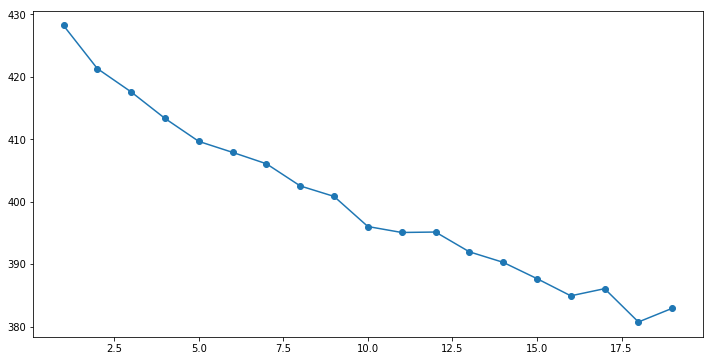

In [12]:
cluster_range = range( 1, 20 )
cluster_errors = []

for num_clusters in cluster_range:
  clusters = KMeans( num_clusters )
  clusters.fit(tfidf_matrix)
  cluster_errors.append( clusters.inertia_ )

clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )

plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o" )

In [13]:
# from sklearn.cluster import KMeans
# from sklearn import metrics
# from scipy.spatial.distance import cdist
# import numpy as np
# import matplotlib.pyplot as plt

# distortions = []
# K = range(1,10)
# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(tfidf_matrix)
#     kmeanModel.fit(tfidf_matrix)
#     distortions.append(sum(np.min(cdist(tfidf_matrix, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])


In [14]:
num_clusters = 6

#LDA Topic Discovery
#lda.fit(tf)

#Kmean Clustering
km = KMeans(
    n_clusters = num_clusters, 
    init       = 'k-means++', 
    random_state = 999991
)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 481 ms, sys: 4.96 ms, total: 486 ms
Wall time: 249 ms


In [15]:
joblib.dump(km,  'doc_cluster.pkl')
km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [16]:
len( clusters )

446

In [17]:
column_values = pd.Series(clusters)
if 'cluster' not in df.columns:
    df.insert(loc=0, column='cluster', value=column_values)

df.head(5)

,cluster,feedback
0,5.0,La encargada del local me quiso robar 300 peso...
1,3.0,No recomiendo la atención. en la sucursal no e...
2,4.0,"Mala atención en el local, no voy más."
3,2.0,"USUARIO PEDORRO, LO PAGÁS Y HASTA NO TE LLEGUE..."
5,4.0,Espero que mejoren la atención al cliente.


In [18]:
df['cluster'].value_counts()

0.0    156
2.0     89
5.0     59
1.0     44
4.0     41
3.0     33
Name: cluster, dtype: int64

In [19]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
terms = tfidf_vectorizer.get_feature_names()

cluster_names  = dict()
cluster_colors =  dict()

for i in range(num_clusters):
    top_ten_words = [ terms[ind] for ind in order_centroids[i, :4]]
    print( "Cluster {idx:d} {words:s}".format( idx=i, words= ', '.join( top_ten_words)  ) )
    cluster_names[i] = ', '.join( top_ten_words) 
    
for idx, val in enumerate( sns.color_palette("cubehelix", num_clusters ).as_hex() ):
    cluster_colors[idx] = val

#set up colors per clusters using a dict
cluster_names

Cluster 0 factura, entrega, bien, dias
Cluster 1 compra, producto, retirar, retirar producto
Cluster 2 producto, retirar, dia, compre
Cluster 3 recomiendo, productos, vendedor, atencion
Cluster 4 mala, mala atencion, atencion, experiencia
Cluster 5 atencion, mal, dinero, pesima


{0: 'factura, entrega, bien, dias',
 1: 'compra, producto, retirar, retirar producto',
 2: 'producto, retirar, dia, compre',
 3: 'recomiendo, productos, vendedor, atencion',
 4: 'mala, mala atencion, atencion, experiencia',
 5: 'atencion, mal, dinero, pesima'}

In [20]:
# two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=99991)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

In [21]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [22]:
#define custom toolbar location
class TopToolbar(mpld3.plugins.PluginBase):
    """Plugin for moving toolbar to top of figure"""

    JAVASCRIPT = """
    mpld3.register_plugin("toptoolbar", TopToolbar);
    TopToolbar.prototype = Object.create(mpld3.Plugin.prototype);
    TopToolbar.prototype.constructor = TopToolbar;
    function TopToolbar(fig, props){
        mpld3.Plugin.call(this, fig, props);
    };

    TopToolbar.prototype.draw = function(){
      // the toolbar svg doesn't exist
      // yet, so first draw it
      this.fig.toolbar.draw();

      // then change the y position to be
      // at the top of the figure
      this.fig.toolbar.toolbar.attr("x", 150);
      this.fig.toolbar.toolbar.attr("y", 400);

      // then remove the draw function,
      // so that it is not called again
      this.fig.toolbar.draw = function() {}
    }
    """
    def __init__(self):
        self.dict_ = {"type": "toptoolbar"}

#define custom css to format the font and to remove the axis labeling
css = """
text.mpld3-text, div.mpld3-tooltip {
    font-family: Arial, Helvetica, sans-serif;
    font-weight: bold;
    font-size: 15px;
    opacity: 1.0;
    padding: 2px;
    border: 1px;
    background: #999;
    color: white;
    opacity: 0.9;
}

g.mpld3-xaxis, g.mpld3-yaxis {
    display: none; 
}
"""


In [24]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
titles = df['feedback']
dfv = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=titles)) 

#group by cluster
groups = dfv.groupby('label')

# Plot 
fig, ax = plt.subplots(figsize=(14,6)) #set plot size
ax.margins(0.03) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    points = ax.plot(
                group.x, group.y, 
                marker='o', 
                linestyle='', 
                ms=12, 
                label=cluster_names[name], 
                mec='none', 
                color=cluster_colors[name]
            )
    ax.set_aspect('auto')
    labels = [i for i in group.title]
    
    #set tooltip using points, labels and the already defined 'css'
    tooltip = mpld3.plugins.PointHTMLTooltip(
                                points[0], 
                                labels,
                                voffset=10, 
                                hoffset=10, 
                                css=css
                            )
    #connect tooltip to fig
    mpld3.plugins.connect(fig, tooltip, TopToolbar())    
    
    #set tick marks as blank
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    
    #set axis as blank
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)

    
ax.legend(numpoints=1, loc="upper left") #show legend with only one dot

mpld3.display() #show the plot

#uncomment the below to export to html
#html = mpld3.fig_to_html(fig)
#print(html)